In [1]:
import sys
sys.path.append("/home/conradb/git/ifg-ssl")
import skimage.io

# pytorch + fastai imports
from fastai.vision.all import *
import torch
import torchvision
from torchvision import transforms

# local module imports
import dino.vision_transformer as vit
from dino.visualize_attn import display_instances

In [2]:
model = 'vit_small'
patch_size = 16
image_path = '.'
image_size = (480,480)
output_dir = 'imagenette_attn_plots'
threshold = 0.6

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model = vit.__dict__[model](patch_size=patch_size, num_classes=0)
for p in model.parameters():
        p.requires_grad = False
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [5]:
state_dict = torch.load('/home/conradb/git/ifg-ssl/dino/dino_checkpoints/dino_imagenette_320_ckpt_v1.pth', map_location="cpu")

state_dict = state_dict["teacher"]

In [6]:
# remove `module.` prefix
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove `backbone.` prefix induced by multicrop wrapper
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

msg = model.load_state_dict(state_dict, strict=False)
print(msg)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [7]:
%matplotlib inline
path = untar_data(URLs.IMAGENETTE_320)
val_imgs = get_image_files(path/'val')

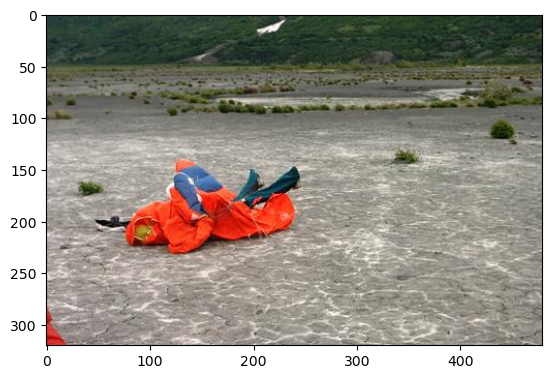

In [8]:
image = Image.open(val_imgs[2630], 'r')
plt.imshow(np.asarray(image))

In [9]:
with open(val_imgs[2630], 'rb') as f:
    img = Image.open(f)
    img = img.convert('RGB')

In [10]:
print(img)

<PIL.Image.Image image mode=RGB size=480x320>


In [11]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

img = transform(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


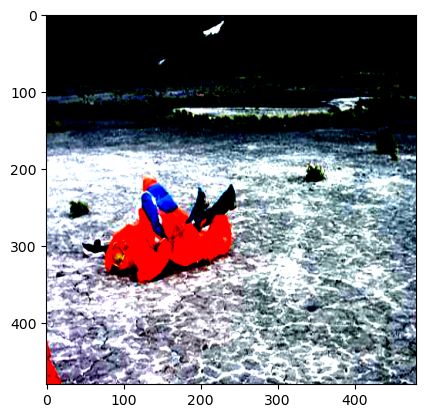

In [12]:
plt.imshow(np.asarray(img).transpose(1,2,0))

In [13]:
 # make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
print(w, h)
img = img[:, :w, :h].unsqueeze(0)
print(img.shape)

480 480
torch.Size([1, 3, 480, 480])


In [14]:
w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size
print(w_featmap, h_featmap)

30 30


In [15]:
attentions = model.get_last_selfattention(img.to(device))
nh = attentions.shape[1] # number of head
print(attentions.shape)
# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

torch.Size([1, 6, 901, 901])
torch.Size([6, 900])


In [16]:
if threshold is not None:
        # we keep only a certain percentage of the mass
        val, idx = torch.sort(attentions)
        val /= torch.sum(val, dim=1, keepdim=True)
        cumval = torch.cumsum(val, dim=1)
        th_attn = cumval > (1 - threshold)
        idx2 = torch.argsort(idx)
        for head in range(nh):
            th_attn[head] = th_attn[head][idx2[head]]
        th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
        # interpolate
        th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

In [17]:
attentions = attentions.reshape(nh, w_featmap, h_featmap)
print(attentions.shape)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
print(attentions.shape)

torch.Size([6, 30, 30])
(6, 480, 480)


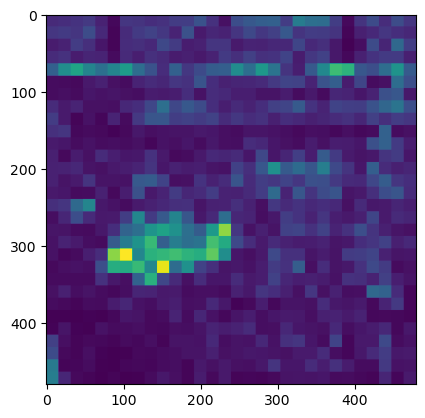

In [18]:
plt.imshow(attentions[2, :, :])

In [19]:
# save attentions heatmaps
os.chdir(os.path.join(os.getcwd(), 'ifg-ssl'))
os.makedirs(output_dir, exist_ok=True)

torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
for j in range(nh):
        fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attentions[j], format='png')
        print(f"{fname} saved.")

imagenette_attn_plots/attn-head0.png saved.
imagenette_attn_plots/attn-head1.png saved.
imagenette_attn_plots/attn-head2.png saved.
imagenette_attn_plots/attn-head3.png saved.
imagenette_attn_plots/attn-head4.png saved.
imagenette_attn_plots/attn-head5.png saved.


imagenette_attn_plots/mask_th0.6_head0.png saved.
imagenette_attn_plots/mask_th0.6_head1.png saved.
imagenette_attn_plots/mask_th0.6_head2.png saved.
imagenette_attn_plots/mask_th0.6_head3.png saved.
imagenette_attn_plots/mask_th0.6_head4.png saved.
imagenette_attn_plots/mask_th0.6_head5.png saved.


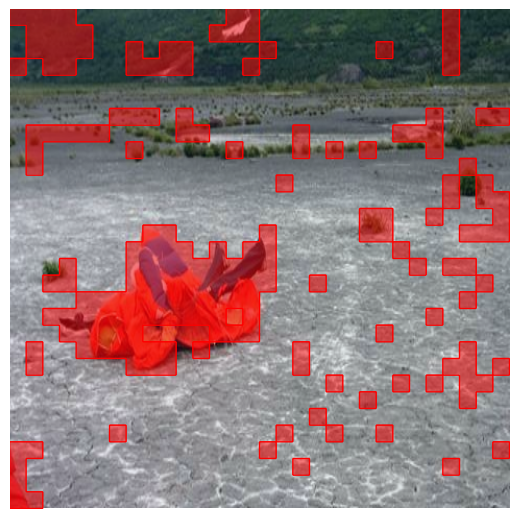

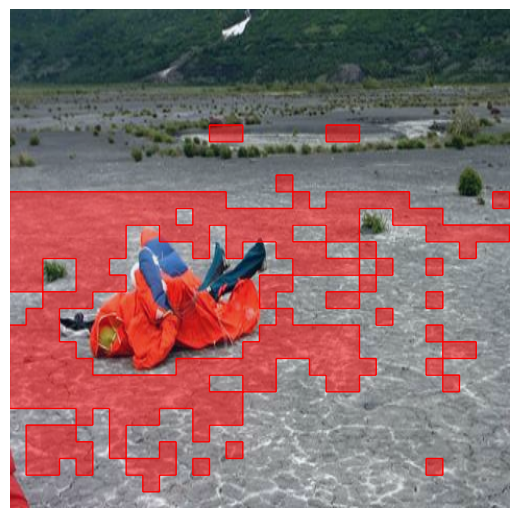

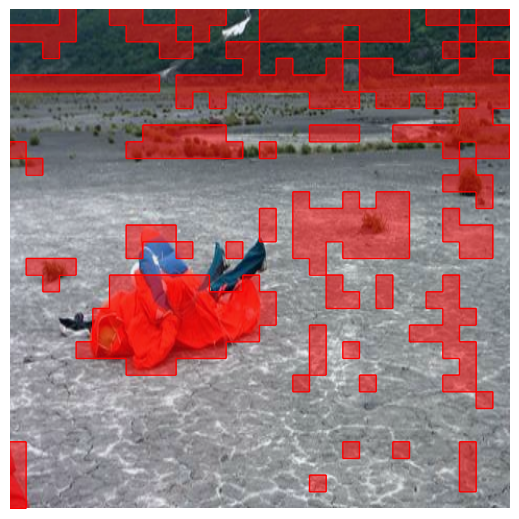

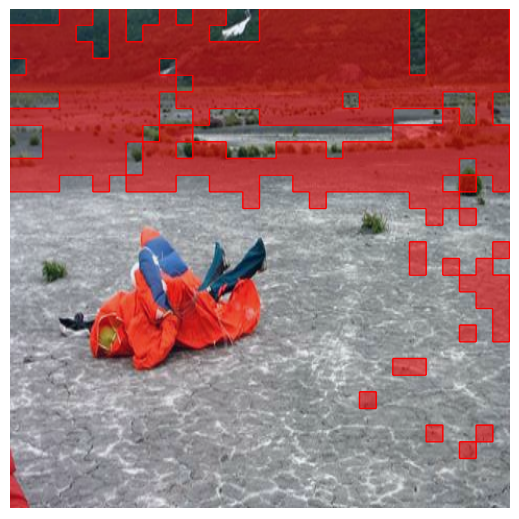

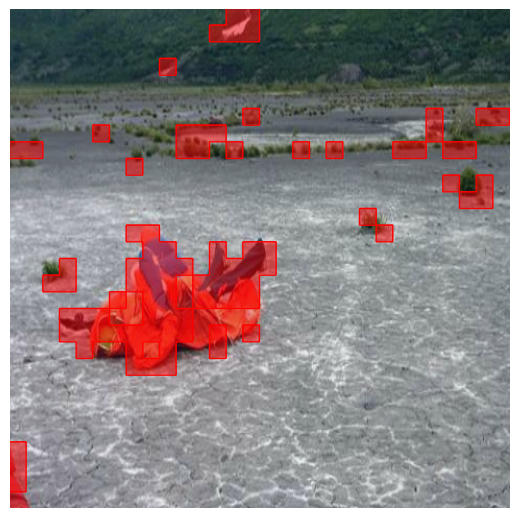

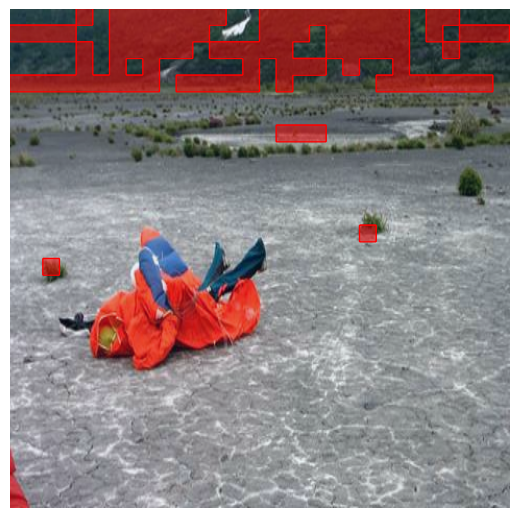

In [20]:
if threshold is not None:
        image = skimage.io.imread(os.path.join(output_dir, "img.png"))
        for j in range(nh):
            display_instances(image, th_attn[j], fname=os.path.join(output_dir, "mask_th" + str(threshold) + "_head" + str(j) +".png"), blur=False)